In [385]:
import wandb
#from wandb import Api
from collections import defaultdict
import pandas as pd
import numpy as np

import random

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display_html
import os

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [386]:
HUES = {}
# HUES["GCN-Transformer"] = "Red"
# HUES["GCN-Avg"] = "Purple"
# HUES["GCN"] = "Black"
# #HUES["DBMS (instance-tuned)"] = "Gray"

# HUES["DBMS-all"] = "Gray"


# HUES["GCN-Pretrained-Latent"] = "Blue"
# HUES["GCN-Pretrained"] = "Green"
# HUES["GCN-PretrainedT-CurrentDB"] = "Gray"
# HUES["GCN-PretrainedT-NoCurrentDB"] = "Green"
# HUES["GCN-PreatinedT-NoCurrentDB-NoActualFeats"] = "Black"


BASELINES = ["DBMS (TestEnv)", "DBMS (TestDB + TestEnv)"]

HUES["DBMS (TestEnv)"] = "Red"
HUES["DBMS (TestDB + TestEnv)"] = "Violet"

#HUES["Pretrained Environment Transformer"] = "Green"

HUES["GCN (TestDB)"] = "Black"
HUES["GCN + LPT"] = "Green"
HUES["GCN (TestDB + TestEnv)"] = "Purple"
HUES["GCN-Transformer (TestDB)"] = "Gray"

In [387]:
api = wandb.Api()

In [388]:
bruns = api.runs("pari/LatencyPredictor",
    {"$and": [
      {"config.alg": "dbms"},
      {"$or": [
            {"$and": [
                {"tags":"single-final9-min-01-baseline"},
                #{"tags":"single-stack-final9-min-01-baseline"},
            ]},
      ]} 
    ]
    })

print(f"Found {len(bruns)} runs")

Found 3 runs


In [389]:
import time
start = time.time()

bdfs = []

cur_run = None
for run in bruns:
    skip = False
    if skip:
        continue
    if run.State != "finished":
        print("not finished!")
        cur_run = run
        continue
    
    data = defaultdict(list)
    data["Tags"].append(run.Tags)
    data["name"].append(run.name)
    
    
    for k,v in run.config.items():
        if not k.startswith("_") or not k.contains("/"):
            data[k].append(v)

    for k,v in run.summary._json_dict.items():
        if k.startswith("_"):
            continue
        if "/" in k:
            continue
        data[k].append(v)
        
    bdfs.append(pd.DataFrame(data))

print("took: ", time.time()-start)
print(len(bdfs))

bdf = pd.concat(bdfs)
#bdf = bdf[bdf["config"] == "configs/baselines/config_dbms_imdb.yaml"]
print(len(bdf))

took:  0.01182103157043457
3
3


In [390]:
bdf[["Final-LatencyQError-test-mean", "Final-LatencyQError-test_unseen-mean", "dbms_fit_test"]]

,Final-LatencyQError-test-mean,Final-LatencyQError-test_unseen-mean,dbms_fit_test
0,18.042923,26.897645,0
0,18.042923,NaN,0
0,20.202283,17.142025,1


In [391]:
runs = api.runs("pari/LatencyPredictor",
    {"$and": [
      #{"config.eval_epoch": 5},
      #{"config.traindata_dir": "LatencyCollectorResults/background"},
      #{"config.traindata_dir": "LatencyCollectorResults/new"},
      {"$or": [
            {"$or": [
                {"tags":"imdb-final9-ablations-logfiles"},
                {"tags":"imdb-final9-ablations"},
                {"tags":"stack-ablations-logfiles"},
                {"tags": "single-stack-final9-min-01"}
            ]},
      ]} 
    ]
    })

print(f"Found {len(runs)} runs")

Found 545 runs


In [392]:
import time
start = time.time()

dfs = []

cur_run = None
for run in runs:
    skip = False
    if skip:
        continue
    if run.State != "finished":
        cur_run = run
        continue
    
    data = defaultdict(list)
    data["Tags"].append(run.Tags)
    data["name"].append(run.name)
    
    
    for k,v in run.config.items():
        if not k.startswith("_") or not k.contains("/"):
            data[k].append(v)

    for k,v in run.summary._json_dict.items():
        if k.startswith("_"):
            continue
        if "/" in k:
            continue
        data[k].append(v)
        
    dfs.append(pd.DataFrame(data))

print("took: ", time.time()-start)
print(len(dfs))

took:  4.774143934249878
355


In [393]:
df = pd.concat(dfs)

df1 = df[df["config"].str.contains("transfer")]
df1 = df[df["feat_onehot"] == 0]
print("Num transferrable: ", len(df1))

df2 = df[(df["tags"] == "exp1_single,exp2_single,exp3_single,exp7_single_ceb2") &
            (df["split_kind"] == "lt_type-query") &
            ~(df["config"].str.contains("nopretrain"))
        ]

df3 = df[df["config"].str.contains("nopretrain")]
df3 = df3[df3["sys_net_pretrained"] == 0]

df4 = df[(df["split_kind"] == "lt_type-query") & \
          ~(df["config"].str.contains("nopretrain"))
        ]

print(set(df3["seed"]))
df3 = df3.drop_duplicates(["seed"])
print(len(df3))

df = pd.concat([df1,df2, df3,df4])

df = pd.concat([df, bdf])
print(len(df))

Num transferrable:  6
{1, 2, 3, 4}
4
333


In [394]:
df4[["Final-LatencyQError-test-mean"]]

,Final-LatencyQError-test-mean
0,32.919656
0,57.772630
0,15.390508
0,8.874688
0,9.017303
0,7.790295
0,39.203549
0,16.212449
0,10.630413
0,9.796640


In [395]:
set(df["alg"])

{'dbms', 'nn'}

In [396]:
# GCN, GCN-Transformer, GCN-Pretrained, GCN-Pretrained-Latent

PRETRAINED_NAME = False

def get_alg(row):
    if "dbms" == row["alg"] or "dbms-c" == row["alg"]:
        if row["dbms_fit_test"]:
            return "DBMS\n(Test DB,Test Env)"
        else:
            return "DBMS\n(Diff DB,Test Env)"
    
    elif "dbms-all" == row["alg"]:
        return "DBMS-all"
    
    elif "avg" in row["config"]:
        return "GCN-Avg"
    
    elif row["arch"] == "gcn":
        if "train_local_model" in row:
            if "train_env_model" in row and str(row["train_env_model"]) != "nan" and row["train_env_model"]:
                print(row["train_env_model"])
                return "GCN\n(Diff DB,Test Env)"
            elif str(row["train_local_model"]) == "nan" or not row["train_local_model"]:
                return "GCN\n(Test DB,Diff Env)"
            else:
                return "GCN\n(Test DB,Test Env)"
        else:
            return "GCN"
    
    elif row["sys_net_pretrained"] == 0:
        if row["extra_training"]:
            return "Factorized\n(No Pre-training)"
        else:
            return "GCN-Transformer (TestDB)"
    
    elif "evals" in row["config"]:
        if PRETRAINED_NAME:
            pn = row["sys_net_pretrained_fn"]
            mn = "GCN-Pretrained-" + str(row["lr"]) + "extra-training-" + str(row["extra_training"])
            mn += "wd-" + str(row["weight_decay"])
            mn += "-" + pn
            return mn
        else:
            if row["sys_net_pretrained_fn"] == "models4/concurrent_noimdb_randomsplit_test90.wt":
                return "Factorized (LPT)"
            elif row["sys_net_pretrained_fn"] == "models5/mixed_nostack_logfeats_cols.wt":
                return "Factorized (LPT)"
            else:
                return row["sys_net_pretrained_fn"]
    else:
        return None
    
def get_final_alg(row):
    if "dbms" == row["alg"] or "dbms-c" == row["alg"]:
        if row["dbms_fit_test"]:
            return "DBMS\n(Test DB,Test Env)"
        else:
            return "DBMS\n(Diff DB,Test Env)"
    
    elif "dbms-all" == row["alg"]:
        return "DBMS-all"
    
    elif "avg" in row["config"]:
        return "GCN-Avg"
    
    elif row["arch"] == "gcn":
        if "train_local_model" in row:
            if "train_env_model" in row and str(row["train_env_model"]) != "nan" and row["train_env_model"]:
                print(row["train_env_model"])
                return "GCN\n(Diff DB,Test Env)"
            elif str(row["train_local_model"]) == "nan" or not row["train_local_model"]:
                return "GCN\n(Test DB,Diff Env)"
            else:
                return "GCN\n(Test DB,Test Env)"
        else:
            return "GCN"
    
    elif row["sys_net_pretrained"] == 0:
        if row["extra_training"]:
            return "Factorized\n(No Pre-training)"
        else:
            return "GCN-Transformer (TestDB)"
    
    elif "evals" in row["config"]:
        if PRETRAINED_NAME:
            pn = row["sys_net_pretrained_fn"]
            mn = "GCN-Pretrained-" + str(row["lr"]) + "extra-training-" + str(row["extra_training"])
            mn += "wd-" + str(row["weight_decay"])
            mn += "-" + pn
            return mn
        else:
            if row["sys_net_pretrained_fn"] == "models4/concurrent_noimdb_randomsplit_test90.wt":
                return "Factorized (LPT)"
            elif row["sys_net_pretrained_fn"] == "models5/mixed_nostack_logfeats_cols.wt":
                return "Factorized (LPT)"
            else:
                return row["sys_net_pretrained_fn"]
    else:
        return None

def get_workload(row):
    if "dbms" in row["alg"].lower():
        return "IMDb"
    
    if "stack" in row["tags"]:
        return "Stack"
    elif "tpch" in row["tags"]:
        return "Tpch"
    elif "zdb" in row["tags"]:
        return "zdbs"
    else:
        return "IMDb"
    
    
df["Estimator"] = df.apply(lambda x: get_final_alg(x),axis=1)
df["alg"] = df.apply(lambda x: get_alg(x),axis=1)
df["workload"] = df.apply(lambda x: get_workload(x),axis=1)

2.0
3.0
5.0
4.0
1.0
6.0
2.0
3.0
5.0
4.0
1.0
6.0


In [397]:
df = df[df["alg"].notna()]

In [398]:
print(len(df))
print(set(df["Estimator"]))
print(set(df["num_instances"]))
print(set(df["seed"]))
print(set(df["config"]))
print("pretrain: " , set(df["sys_net_pretrained_fn"]))
print(set(df["alg"]))
print(set(df["tags"]))
print(set(df["workload"]))
print(set(df["tags"]))
print(set(df["seed"]))
print(df.keys())

333
{'models4/ablation_logs_pressure_io.wt', 'models4/concurrent_noimdb_randomsplit_test99.wt', 'models4/concurrent_noimdb_logfeats_col_single-instance.wt', 'models4/ablation_stack_logs_pressure_mem.wt', 'models4/ablation_stack_logs_pressure_io.wt', 'GCN-Transformer (TestDB)', 'models4/ablation_logs_mem.wt', 'models4/ablation_logs_interrupts.wt', 'models4/ablation_stack_logs_pressure_load.wt', 'GCN\n(Diff DB,Test Env)', 'models4/concurrent_noimdb_logfeats_col_test099.wt', 'models4/ablation_logs_filesystem.wt', 'models4/ablation_stack_logs_interrupts.wt', 'models4/ablation_stack_logs_swap.wt', 'Factorized (LPT)', 'models4/ablation_logs_cpu_utilization.wt', 'models4/ablation_logs_inode.wt', 'models4/ablation_stack_logs_inode.wt', 'models4/ablation_logs_context_switch.wt', 'models4/ablation_stack_logs_filesystem.wt', 'models4/mixed_nostack_logfeats_cols_randomsplit_test90.wt', 'DBMS\n(Test DB,Test Env)', 'models4/ablation_stack_logs_io1.wt', 'Factorized\n(No Pre-training)', 'models4/ablat

In [399]:
#df = df[df["alg"] != "DBMS-all"]
#df = df[df["alg"] != "GCN-Pretrained-Latent"]

In [400]:
print(set(df["sys_net_pretrained_fn"]))
#print(set(df["Tag"]))

{'models4/ablation_logs_pressure_io.wt', 'models4/concurrent_noimdb_randomsplit_test99.wt', 'models4/concurrent_noimdb_logfeats_col_single-instance.wt', 'models4/ablation_stack_logs_pressure_mem.wt', 'models4/ablation_stack_logs_pressure_io.wt', 'models4/ablation_logs_mem.wt', 'models4/ablation_logs_interrupts.wt', 'models4/ablation_stack_logs_pressure_load.wt', None, 'models4/concurrent_noimdb_logfeats_col_test099.wt', 'models4/ablation_logs_filesystem.wt', 'models4/noimdb_log_nostatic_logfeats.wt', 'models4/ablation_stack_logs_interrupts.wt', 'models4/ablation_stack_logs_swap.wt', 'models4/noactual_mixed_noimdb_logfeats_col.wt', 'models4/concurrent_noimdb_randomsplit_test90.wt', 'models4/ablation_logs_cpu_utilization.wt', 'models4/ablation_logs_inode.wt', 'models4/ablation_stack_logs_inode.wt', 'models4/ablation_logs_context_switch.wt', 'models4/ablation_stack_logs_filesystem.wt', 'models4/mixed_nostack_logfeats_cols_randomsplit_test90.wt', 'models4/ablation_stack_logs_io1.wt', 'mode

In [401]:
#df = df[df["weight_decay"] == 0.1]

In [402]:
pd.set_option('display.max_rows', 500)

tmp = df[df["num_instances"] == 1]
tmp[["seed", "num_instances", "alg", "extra_training", "weight_decay", "lr", "Final-LatencyQError-test-mean", "Final-LatencyAE-test-mean" , "weight_decay", "Final-LatencyMSE-test-mean", 
    "Final-LatencyQError-test-median", "Final-LatencyQError-test-99p"]].sort_values(by="seed")

,seed,num_instances,alg,extra_training,weight_decay,lr,Final-LatencyQError-test-mean,Final-LatencyAE-test-mean,weight_decay,Final-LatencyMSE-test-mean,Final-LatencyQError-test-median,Final-LatencyQError-test-99p
0,0,1,models4/ablation_logs_cpu_utilization.wt,0,1,0.00010,5.948556,55.901224,1,14883.523421,2.690790,53.050331
0,0,1,models4/ablation_logs_inode.wt,0,1,0.00010,7.698559,68.695809,1,20807.846315,2.987257,66.991193
0,0,1,models4/ablation_logs_interrupts.wt,0,1,0.00010,NaN,NaN,1,NaN,NaN,NaN
0,0,1,models4/ablation_logs_context_switch.wt,0,1,0.00010,5.873185,54.007287,1,14205.038651,2.689250,48.142674
0,0,1,models4/ablation_logs_filesystem.wt,0,1,0.00010,7.445024,64.427269,1,17719.552604,3.136459,62.707006
0,0,1,models4/ablation_logs_device_io.wt,0,1,0.00010,5.265431,53.829855,1,15312.226562,2.478403,41.344078
0,0,1,models4/concurrent_noimdb_logfeats_col_test05.wt,0,1,0.00010,6.413125,74.529166,1,25929.943062,2.677879,56.505228
0,0,1,models4/ablation_logs_cpu_utilization.wt,0,1,0.00010,5.948556,55.901224,1,14883.523421,2.690790,53.050331
0,0,1,models4/ablation_logs_context_switch.wt,0,1,0.00010,5.873185,54.007287,1,14205.038651,2.689250,48.142674
0,0,1,models4/ablation_logs_device_io.wt,0,1,0.00010,5.265431,53.829855,1,15312.226562,2.478403,41.344078


In [403]:
print(set(df["alg"]))
print(set(df["Estimator"]))

{'models4/ablation_logs_pressure_io.wt', 'models4/concurrent_noimdb_randomsplit_test99.wt', 'models4/concurrent_noimdb_logfeats_col_single-instance.wt', 'models4/ablation_stack_logs_pressure_mem.wt', 'models4/ablation_stack_logs_pressure_io.wt', 'GCN-Transformer (TestDB)', 'models4/ablation_logs_mem.wt', 'models4/ablation_logs_interrupts.wt', 'models4/ablation_stack_logs_pressure_load.wt', 'GCN\n(Diff DB,Test Env)', 'models4/concurrent_noimdb_logfeats_col_test099.wt', 'models4/ablation_logs_filesystem.wt', 'models4/ablation_stack_logs_interrupts.wt', 'models4/ablation_stack_logs_swap.wt', 'Factorized (LPT)', 'models4/ablation_logs_cpu_utilization.wt', 'models4/ablation_logs_inode.wt', 'models4/ablation_stack_logs_inode.wt', 'models4/ablation_logs_context_switch.wt', 'models4/ablation_stack_logs_filesystem.wt', 'models4/mixed_nostack_logfeats_cols_randomsplit_test90.wt', 'DBMS\n(Test DB,Test Env)', 'models4/ablation_stack_logs_io1.wt', 'Factorized\n(No Pre-training)', 'models4/ablation_

In [404]:
#df = df[df["seed"] < 4]

In [405]:
single_df = df[~df["config"].str.contains("mt")]
single_df_imdb = single_df[single_df["config"].str.contains("noimdb")]
#tmp2 = df[df["config"].str.contains("mt")]
single_df_stack = single_df[single_df["config"].str.contains("nostack")]

In [406]:
single_df_imdb.groupby(["Estimator"])["Final-LatencyQError-test_unseen-mean"].describe().reset_index().sort_values(by="mean")

,Estimator,count,mean,std,min,25%,50%,75%,max
18,models4/concurrent_noimdb_logfeats_col_test09.wt,8.0,6.235161,0.473481,5.587039,6.044623,6.261322,6.451860,6.830962
17,models4/concurrent_noimdb_logfeats_col_test05.wt,8.0,6.495519,1.182669,5.304435,5.456755,6.420555,7.459319,7.836531
1,Factorized (LPT),20.0,6.755366,0.844984,5.773417,6.239942,6.603193,7.336852,8.692348
20,models4/concurrent_noimdb_randomsplit_test99.wt,10.0,7.434568,1.311731,5.914445,6.723296,6.746562,8.584924,9.203611
4,models4/ablation_logs_device_io.wt,8.0,7.621182,2.523426,5.418138,5.576222,6.910329,8.955289,11.245931
10,models4/ablation_logs_paging.wt,8.0,7.899534,1.066165,6.472853,7.324007,7.964934,8.540461,9.195414
12,models4/ablation_logs_pressure_io.wt,8.0,8.470750,2.214176,6.312942,6.473271,8.327011,10.324490,10.916036
3,models4/ablation_logs_cpu_utilization.wt,8.0,9.157684,1.492978,7.358277,8.318738,9.029591,9.868537,11.213279
19,models4/concurrent_noimdb_logfeats_col_test099.wt,10.0,9.906065,6.137514,5.902796,6.884024,6.884985,8.419266,21.439255
13,models4/ablation_logs_pressure_load.wt,8.0,10.215202,2.632604,7.434656,8.863778,9.626313,10.977737,14.173525


In [407]:
single_df_stack.groupby(["Estimator"])["Final-LatencyQError-test_unseen-mean"].describe().reset_index().sort_values(by="mean")

,Estimator,count,mean,std,min,25%,50%,75%,max
4,"GCN\n(Test DB,Test Env)",6.0,4.731250,0.475672,4.047765,4.482690,4.783456,4.908866,5.439721
20,models4/concurrent_nostack_randomsplit_test90.wt,4.0,5.970263,1.452266,4.969687,5.220184,5.393076,6.143154,8.125212
1,Factorized (LPT),4.0,6.137230,0.650020,5.357841,5.736103,6.203555,6.604683,6.783970
21,models4/mixed_nostack_logfeats_cols_randomspli...,4.0,6.970686,1.420509,4.995381,6.683852,7.252508,7.539343,8.382348
16,models4/ablation_stack_logs_pressure_io.wt,4.0,7.951723,2.118314,5.602547,6.999816,7.738578,8.690485,10.727189
7,models4/ablation_stack_logs_cpu_utilization.wt,4.0,10.911548,5.140834,6.740320,7.035315,9.594850,13.471084,17.716174
0,Factorized\n(No Pre-training),4.0,11.395031,3.943214,6.566659,10.123559,11.394730,12.666202,16.224005
17,models4/ablation_stack_logs_pressure_load.wt,4.0,13.004894,4.505812,7.053922,10.847142,13.870464,16.028216,17.224725
14,models4/ablation_stack_logs_paging.wt,4.0,13.958646,3.380872,10.258004,11.786948,13.811169,15.982867,17.954242
12,models4/ablation_stack_logs_io1.wt,4.0,14.469906,5.648287,9.755283,11.475701,12.747590,15.741796,22.629162


In [408]:
log_dfs = single_df_imdb[single_df_imdb["Estimator"].str.contains("ablation_logs")]
our_df = single_df_imdb[single_df_imdb["Estimator"] == "Factorized (LPT)"]
log_dfs = pd.concat([log_dfs, our_df])
log_dfs.groupby(["Estimator"])["Final-LatencyQError-test_unseen-mean"].describe().reset_index().sort_values(by="mean")

,Estimator,count,mean,std,min,25%,50%,75%,max
0,Factorized (LPT),20.0,6.755366,0.844984,5.773417,6.239942,6.603193,7.336852,8.692348
3,models4/ablation_logs_device_io.wt,8.0,7.621182,2.523426,5.418138,5.576222,6.910329,8.955289,11.245931
9,models4/ablation_logs_paging.wt,8.0,7.899534,1.066165,6.472853,7.324007,7.964934,8.540461,9.195414
11,models4/ablation_logs_pressure_io.wt,8.0,8.470750,2.214176,6.312942,6.473271,8.327011,10.324490,10.916036
2,models4/ablation_logs_cpu_utilization.wt,8.0,9.157684,1.492978,7.358277,8.318738,9.029591,9.868537,11.213279
12,models4/ablation_logs_pressure_load.wt,8.0,10.215202,2.632604,7.434656,8.863778,9.626313,10.977737,14.173525
1,models4/ablation_logs_context_switch.wt,8.0,11.876770,6.046785,6.660139,7.852810,9.811885,13.835844,21.223170
7,models4/ablation_logs_io1.wt,8.0,12.759260,8.364327,7.453651,7.682325,8.673150,13.750086,26.237088
8,models4/ablation_logs_mem.wt,8.0,13.359594,11.051524,5.881305,6.689111,8.217578,14.888061,31.121914
5,models4/ablation_logs_inode.wt,8.0,14.558867,8.986148,7.741592,8.056469,10.991102,17.493500,28.511672


In [409]:
log_dfs_stack = single_df_stack[single_df_stack["Estimator"].str.contains("ablation_stack_logs")]
our_df_stack = single_df_stack[single_df_stack["Estimator"] == "Factorized (LPT)"]
log_dfs_stack = pd.concat([log_dfs_stack, our_df_stack])
log_dfs_stack.groupby(["Estimator"])["Final-LatencyQError-test_unseen-mean"].describe().reset_index().sort_values(by="mean")

,Estimator,count,mean,std,min,25%,50%,75%,max
0,Factorized (LPT),4.0,6.137230,0.650020,5.357841,5.736103,6.203555,6.604683,6.783970
11,models4/ablation_stack_logs_pressure_io.wt,4.0,7.951723,2.118314,5.602547,6.999816,7.738578,8.690485,10.727189
2,models4/ablation_stack_logs_cpu_utilization.wt,4.0,10.911548,5.140834,6.740320,7.035315,9.594850,13.471084,17.716174
12,models4/ablation_stack_logs_pressure_load.wt,4.0,13.004894,4.505812,7.053922,10.847142,13.870464,16.028216,17.224725
9,models4/ablation_stack_logs_paging.wt,4.0,13.958646,3.380872,10.258004,11.786948,13.811169,15.982867,17.954242
7,models4/ablation_stack_logs_io1.wt,4.0,14.469906,5.648287,9.755283,11.475701,12.747590,15.741796,22.629162
4,models4/ablation_stack_logs_filesystem.wt,4.0,14.691562,7.992164,7.897052,10.262552,12.362358,16.791368,26.144478
14,models4/ablation_stack_logs_swap.wt,4.0,16.356554,6.092286,11.231988,12.446495,14.652970,18.563029,24.888287
8,models4/ablation_stack_logs_mem.wt,4.0,17.438062,14.151343,6.133444,8.490703,13.016747,21.964106,37.585307
1,models4/ablation_stack_logs_context_switch.wt,4.0,18.808055,8.819046,9.638757,12.956778,17.979977,23.831253,29.633510


In [410]:
estimator_log_mapping_stack = {
    'Factorized (LPT)' : 'All logs',
    'models4/ablation_stack_logs_context_switch.wt': 'Task/Switching (-w)',
    'models4/ablation_stack_logs_cpu_utilization.wt': 'CPU Utilization (-u)',
    'models4/ablation_stack_logs_device_io.wt': 'Block Device (-d)',
    'models4/ablation_stack_logs_filesystem.wt': 'Filesystem Usage (-F)',
    'models4/ablation_stack_logs_inode.wt': 'File Table Status (-v)',
    'models4/ablation_stack_logs_interrupts.wt': 'Interrupts (-I)',
    'models4/ablation_stack_logs_io1.wt': 'I/O Rate (-b)',
    'models4/ablation_stack_logs_mem.wt': 'Memory Usage (-r)',
    'models4/ablation_stack_logs_paging.wt': 'Paging Stats (-B)',
    'models4/ablation_stack_logs_pressure_cpu.wt': 'System Load and\nPressure-Stall (CPU)',
    'models4/ablation_stack_logs_pressure_io.wt': 'System Load and\nPressure-Stall (I/O)',
    'models4/ablation_stack_logs_pressure_load.wt': 'System Load and\nPressure-Stall (Load)',
    'models4/ablation_stack_logs_pressure_mem.wt': 'System Load and\nPressure-Stall (Mem)',
    'models4/ablation_stack_logs_swap.wt': 'Swap Space (-S)'
}

# Define the mapping dictionary
estimator_log_mapping = {
    'Factorized (LPT)' : 'All logs',
    'models4/ablation_logs_context_switch.wt': 'Task/Switching (-w)',
    'models4/ablation_logs_cpu_utilization.wt': 'CPU Utilization (-u)',
    'models4/ablation_logs_device_io.wt': 'Block Device (-d)',
    'models4/ablation_logs_filesystem.wt': 'Filesystem Usage (-F)',
    'models4/ablation_logs_inode.wt': 'File Table Status (-v)',
    'models4/ablation_logs_interrupts.wt': 'Interrupts (-I)',
    'models4/ablation_logs_io1.wt': 'I/O Rate (-b)',
    'models4/ablation_logs_mem.wt': 'Memory Usage (-r)',
    'models4/ablation_logs_paging.wt': 'Paging Stats (-B)',
    'models4/ablation_logs_pressure_cpu.wt': 'System Load and\nPressure-Stall (CPU)',
    'models4/ablation_logs_pressure_io.wt': 'System Load and\nPressure-Stall (I/O)',
    'models4/ablation_logs_pressure_load.wt': 'System Load and\nPressure-Stall (Load)',
    'models4/ablation_logs_pressure_mem.wt': 'System Load and\nPressure-Stall (Mem)',
    'models4/ablation_logs_swap.wt': 'Swap Space (-S)'
}

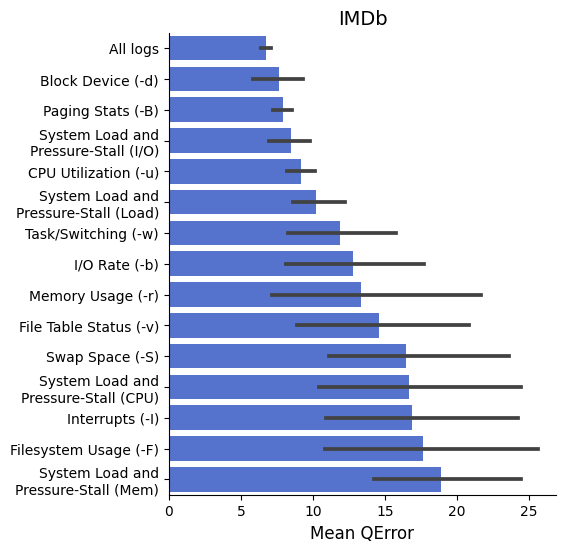

In [411]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd



# Assuming 'log_dfs' is your filtered DataFrame
# Map the 'Estimator' column using the dictionary
log_dfs['Mapped Estimator'] = log_dfs['Estimator'].map(estimator_log_mapping)

# Calculate mean values for each Mapped Estimator
estimator_means = log_dfs.groupby('Mapped Estimator')['Final-LatencyQError-test_unseen-mean'].mean().reset_index()

# Sort the mean values
sorted_means = estimator_means.sort_values(by='Final-LatencyQError-test_unseen-mean')

# Merge sorted mean values back to the original DataFrame
sorted_log_dfs = pd.merge(sorted_means[['Mapped Estimator']], log_dfs, on='Mapped Estimator', how='left')

# Set the color palette to 'RoyalBlue'
sns.set_palette(['RoyalBlue'])

# Create the horizontal bar plot
plt.figure(figsize=(5, 6))  # Adjust the size as needed
bar_plot = sns.barplot(data=sorted_log_dfs, x="Final-LatencyQError-test_unseen-mean", y='Mapped Estimator',
                       color="RoyalBlue")

# Prettify the plot
plt.xlabel("Mean QError", fontsize=12)
plt.ylabel("")  # Removing the ylabel
plt.title("IMDb", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Optional: Remove the top and right spines for a cleaner look
sns.despine()

plt.savefig("Log-Ablations-IMDb.pdf", bbox_inches="tight")
# Show the plot
plt.show()


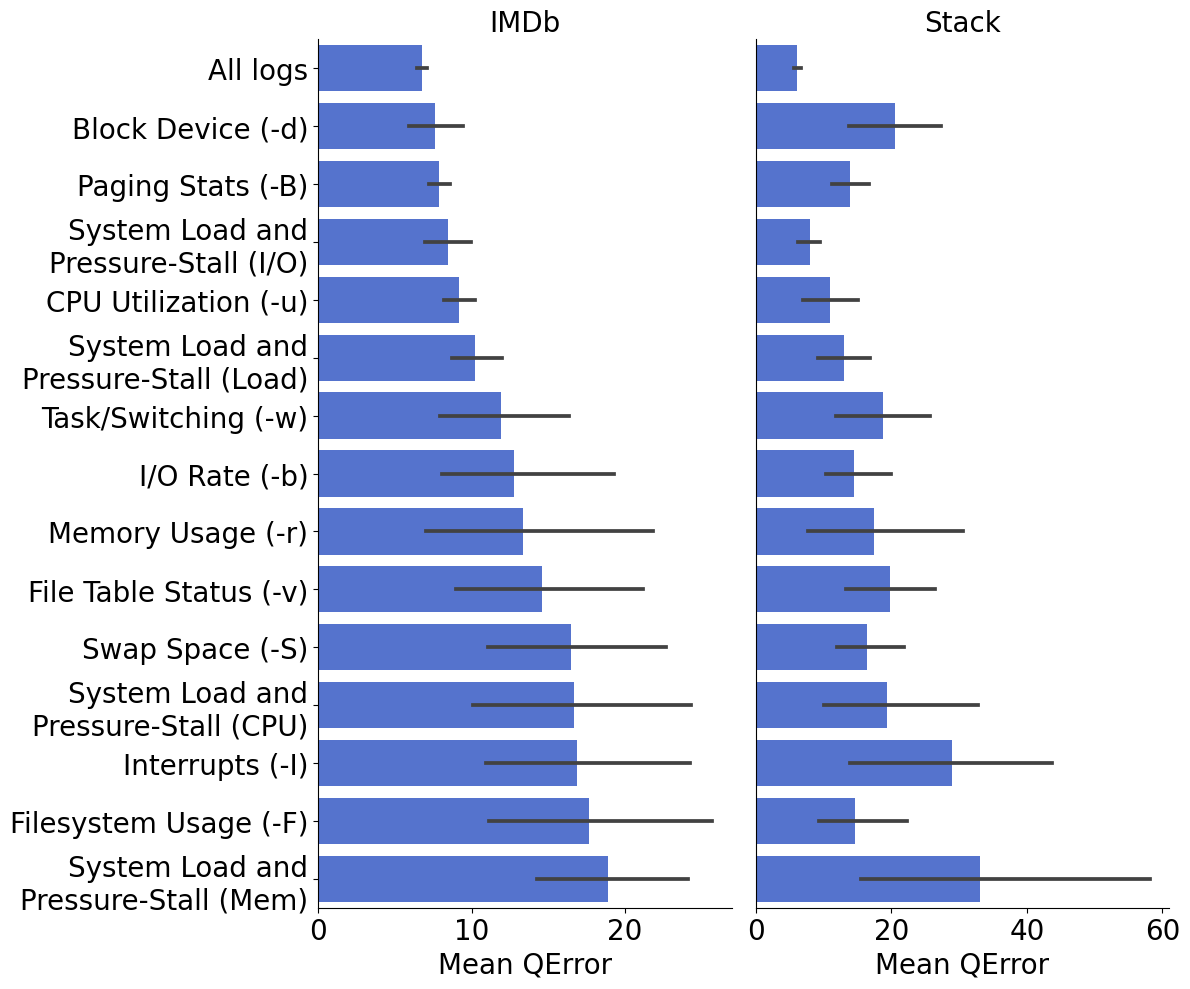

In [416]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define the mapping dictionaries (as previously defined)

# Map the 'Estimator' column using the dictionaries
log_dfs['Mapped Estimator'] = log_dfs['Estimator'].map(estimator_log_mapping)
log_dfs_stack['Mapped Estimator'] = log_dfs_stack['Estimator'].map(estimator_log_mapping_stack)

# Calculate mean values for each Mapped Estimator in log_dfs
estimator_means_log_dfs = log_dfs.groupby('Mapped Estimator')['Final-LatencyQError-test_unseen-mean'].mean().reset_index()

# Sort the means and get the order
sorted_order = estimator_means_log_dfs.sort_values(by='Final-LatencyQError-test_unseen-mean')['Mapped Estimator']

# Create figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 10))

# Function to create a plot
def create_plot(df, ax, order, remove_yticks=False):
    # Merge with the sorted order to ensure common ordering
    merged_df = pd.merge(order.to_frame(), df, on='Mapped Estimator', how='left')
    sns.barplot(data=merged_df, x="Final-LatencyQError-test_unseen-mean", y='Mapped Estimator', color="RoyalBlue", ax=ax)
    ax.set_xlabel("Mean QError", fontsize=20)
    ax.set_ylabel("")  # Removing the ylabel
    ax.tick_params(axis='x', labelsize=20)
    if remove_yticks:
        ax.set_yticks([])  # Removing the y-axis tick marks for the second plot
    else:
        ax.tick_params(axis='y', labelsize=20)
    sns.despine()

# Create the first plot (IMDb)
create_plot(log_dfs, axs[0], sorted_order)

# Create the second plot (Stack) and remove the y-axis tick marks
create_plot(log_dfs_stack, axs[1], sorted_order, remove_yticks=True)

axs[0].set_title("IMDb", fontsize=20)
axs[1].set_title("Stack", fontsize=20)

plt.tight_layout()
plt.savefig("Log-Ablations-Both.pdf", bbox_inches="tight")
plt.show()


In [233]:
tmp2.groupby(["Estimator"])["Final-LatencyQError-test_unseen-mean"].describe().reset_index().sort_values(by="mean")

,index,count,mean,std,min,25%,50%,75%,max


In [199]:
FN_TMP = "NewInstances-{}-{}.pdf"

def plot_metrics(data, metric_median, metric_90p, metric_mean, title, prefix=""):
    fig, axs = plt.subplots(1, 3, figsize=(18,6))
    fig.suptitle(title)
    
    baseline_data = data[data['alg'] == "DBMS (instance-tuned)"]
    
    # Filter out the baseline data from the data being plotted
    data = data[data['alg'] != "DBMS (instance-tuned)"]
    
    if "MSE" in metric_mean:
        use_log = True
    else:
        use_log = False
    
    if not baseline_data.empty:
        baseline_median = baseline_data[metric_median].values[0]
        baseline_90p = baseline_data[metric_90p].values[0]
        baseline_mean = baseline_data[metric_mean].values[0]
    else:
        baseline_median = None
        baseline_90p = None
        baseline_mean = None

    # Plot for Median values
    sns.barplot(data=data, y=metric_median, x="num_instances", hue="Estimator", dodge=True, ax=axs[0])
    if baseline_median is not None:
        axs[0].axhline(baseline_median, color='r', linestyle='--', label='Baseline (Median)')
    axs[0].set_title('Median')

    if use_log:
        axs[0].set_yscale("log")
        
        
    # Plot for 90th Percentile values
    sns.barplot(data=data, y=metric_90p, x="num_instances", hue="Estimator", dodge=True, ax=axs[1])
    if baseline_median is not None:
        axs[1].axhline(baseline_90p, color='r', linestyle='--', label='Baseline (90th Percentile)')
    axs[1].set_title('90th Percentile')
    #if should_use_log_scale(data[metric_90p]):
        
    if use_log:
        axs[1].set_yscale("log")

    # Plot for Mean values
    sns.barplot(data=data, y=metric_mean, x="num_instances", hue="Estimator", dodge=True, ax=axs[2])
    if baseline_median is not None:
        axs[2].axhline(baseline_mean, color='r', linestyle='--', label='Baseline (Mean)')
        
    axs[2].set_title('Mean')
    if use_log:
        axs[2].set_yscale("log")


    # Remove individual legends and add a single legend at the top
    for ax in axs:
        ax.get_legend().remove()
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles + [axs[0].lines[0]], labels + ['Baseline'], loc='upper center', 
               bbox_to_anchor=(0.5, 1.10), ncol=3)

    # Finalize the plot and save
    plt.tight_layout()
    fn = FN_TMP.format(prefix + "IMDb", title.replace(' ', '-'))
    print(fn)
    plt.savefig(fn, bbox_inches="tight")


In [54]:
# tmp = df
# # Plot for MSE
# plot_metrics(tmp, 
#              'Final-LatencyMSE-test-median', 
#              'Final-LatencyMSE-test-90p', 
#              'Final-LatencyMSE-test-mean',
#              'Latency MSE', 
#              prefix="SeenQ-")

# # Plot for Q-Error
# plot_metrics(tmp, 
#              'Final-LatencyQError-test-median', 
#              'Final-LatencyQError-test-90p', 
#              'Final-LatencyQError-test-mean',
#              'Latency Q-Error',
#               prefix="SeenQ-")

# plot_metrics(tmp, 
#              'Final-LatencyRelError-test-median', 
#              'Final-LatencyRelError-test-90p', 
#              'Final-LatencyRelError-test-mean',
#              'Latency Relative Error',
#              prefix="SeenQ-")

# # Plot for AE
# plot_metrics(tmp, 
#              'Final-LatencyAE-test-median', 
#              'Final-LatencyAE-test-90p', 
#              'Final-LatencyAE-test-mean',
#              'Latency Absolute Error',
#               prefix="SeenQ-")


NewInstances-UnseenQIMDb-Latency-Q-Error.pdf


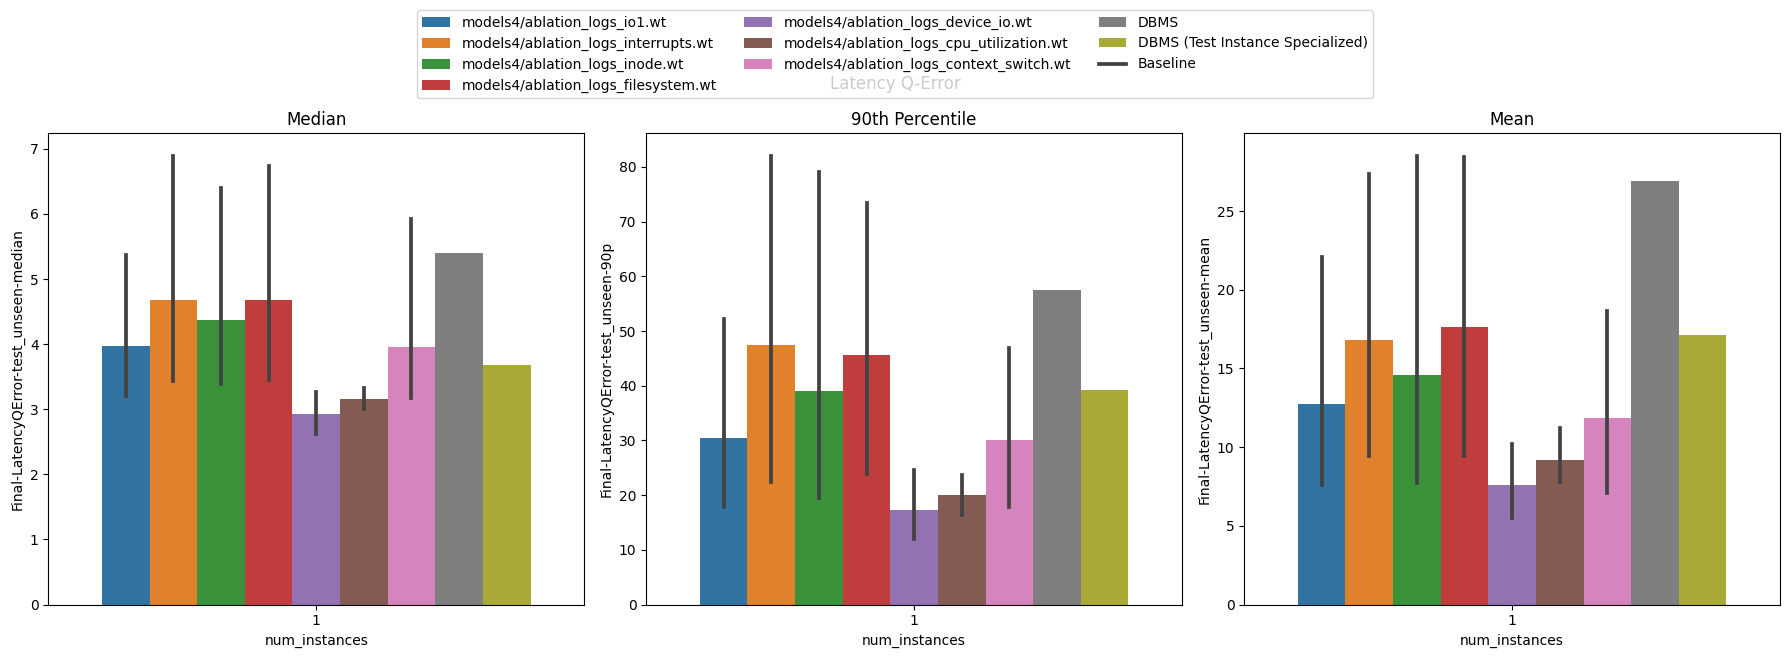

In [55]:
tmp = df
# Plot for MSE
# plot_metrics(tmp, 
#              'Final-LatencyMSE-test_unseen-median', 
#              'Final-LatencyMSE-test_unseen-90p', 
#              'Final-LatencyMSE-test_unseen-mean',
#              'Latency MSE',
#              prefix="UnseenQ")
    

# Plot for Q-Error
plot_metrics(tmp, 
             'Final-LatencyQError-test_unseen-median', 
             'Final-LatencyQError-test_unseen-90p', 
             'Final-LatencyQError-test_unseen-mean',
             'Latency Q-Error',
                 prefix="UnseenQ")

# plot_metrics(tmp, 
#              'Final-LatencyRelError-test_unseen-median', 
#              'Final-LatencyRelError-test_unseen-90p', 
#              'Final-LatencyRelError-test_unseen-mean',
#              'Latency Relative Error',
#                     prefix="UnseenQ")

# Plot for AE
# plot_metrics(tmp, 
#              'Final-LatencyAE-test_unseen-median', 
#              'Final-LatencyAE-test_unseen-90p', 
#              'Final-LatencyAE-test_unseen-mean',
#              'Latency Absolute Error',
#                  prefix="UnseenQ")


In [171]:
# print(set(df["only_workload"]))

# WKS = ["ssb", "ccs", "accidents", "airline"]
# fig,axs = plt.subplots(nrows=1,ncols=4, figsize=(12,5))

# for wi,wk in enumerate(WKS):
#     ax = axs[wi]
#     tmp = df[df["only_workload"] == wk]
#     sns.barplot(data=tmp, x="alg", y='Final-LatencyQError-test_unseen-mean', 
#                 hue="alg", 
#                 dodge=False, ax=ax)
#     ax.legend().remove()

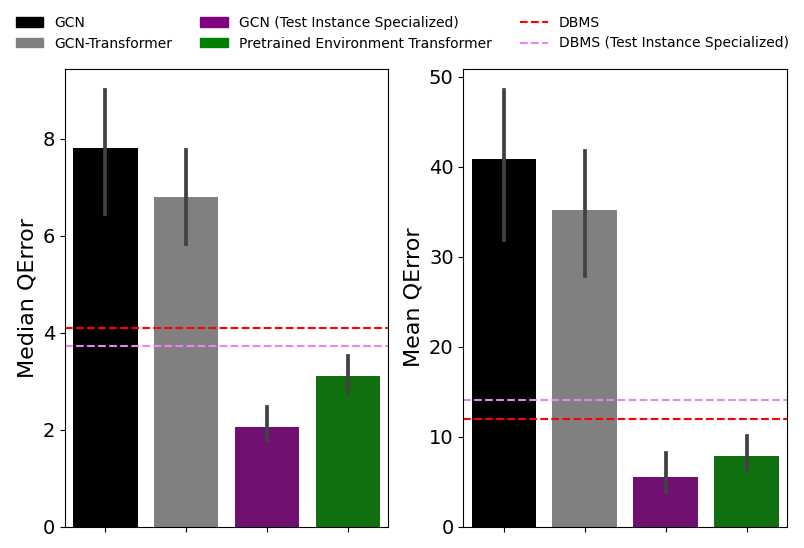

In [174]:
# import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches

#ORDER = ["GCN", "GCN-Transformer", "Pretrained Environment Transformer"]
ORDER = ["GCN", "GCN-Transformer", "GCN (Test Instance Specialized)", "Pretrained Environment Transformer"]

# Assuming df, BASELINES, HUES, and ORDER are defined somewhere in your script

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

# Manually create legend handles for the bar plots
bar_handles = [mpatches.Patch(color=HUES[name], label=name) for name in ORDER]

# First subplot
ax = axs[0]

# Plot the bars
sns.barplot(data=df, x="Estimator", 
            y='Final-LatencyQError-test_unseen-median', 
            hue="Estimator", 
            palette=HUES,
            order=ORDER,
            dodge=False, ax=ax)

# Baseline lines
baseline_handles = []
for estb in BASELINES:
    tmp = df[df["Estimator"] == estb]
    if len(tmp) == 0:
        continue
    bmedian = tmp['Final-LatencyQError-test_unseen-median'].mean()
    line = ax.axhline(bmedian, color=HUES[estb], linestyle='--')
    baseline_handles.append(line)

ax.set_xlabel("")
ax.set_xticklabels([])
ax.set_ylabel("Median QError", fontsize=16)
ax.tick_params(axis='y', labelsize=14)  # Set the font size to 12 for y-axis ticks

ax.legend().remove()  # Remove the auto-generated legend

# Second subplot
ax = axs[1]

sns.barplot(data=df, x="Estimator", 
            y='Final-LatencyQError-test_unseen-mean', 
            hue="Estimator", 
            palette=HUES,
            order=ORDER,
            dodge=False, ax=ax)

ax.set_xticklabels([])
ax.set_xlabel("")
ax.set_ylabel("Mean QError", fontsize=16)
ax.tick_params(axis='y', labelsize=14)  # Set the font size to 12 for y-axis ticks

for estb in BASELINES:
    tmp = df[df["Estimator"] == estb]
    if len(tmp) == 0:
        continue
    bmean = tmp['Final-LatencyQError-test_unseen-mean'].mean()
    ax.axhline(bmean, color=HUES[estb], linestyle='--')

ax.legend().remove()  # Remove the auto-generated legend

# Manually create the legend
if baseline_handles:
    custom_handles = bar_handles + baseline_handles 
    custom_labels = ORDER + ['DBMS', 'DBMS (Test Instance Specialized)']
else:
    custom_handles = bar_handles
    custom_labels = ORDER

fig.legend(handles=custom_handles, labels=custom_labels, 
           loc='upper center', 
           ncol=3, bbox_to_anchor=(0.5, 1.10),
           frameon=False)

plt.tight_layout()
plt.savefig("Eval-MultiTenant-IMDb.pdf", bbox_inches="tight")

In [173]:
set(df["Estimator"])

{'DBMS',
 'DBMS (Test Instance Specialized)',
 'GCN',
 'GCN (Test Instance Specialized)',
 'GCN-Transformer',
 'Pretrained Environment Transformer'}

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

FN_TMP = "NewInstances-{}-{}.pdf"

# Define a function to check if the values have a large range and should be plotted in log scale
def should_use_log_scale(values):
    return max(values) / min(values) > 1000  # Adjust this threshold if needed
    
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metrics2(data, metric_median, metric_90p, metric_mean, title):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(title)

    # Filter out the baseline data
    baseline_data = data[data['alg'] == "DBMS (instance-tuned)"]
    #data = data[data['alg'] != "DBMS (instance-tuned)"]

    if not baseline_data.empty:
        baseline_median = baseline_data[metric_median].values[0]
        baseline_90p = baseline_data[metric_90p].values[0]
        baseline_mean = baseline_data[metric_mean].values[0]
    else:
        baseline_median = None
        baseline_90p = None
        baseline_mean = None

    metrics = [(metric_median, baseline_median, 'Median'),
               (metric_90p, baseline_90p, '90th Percentile'),
               (metric_mean, baseline_mean, 'Mean')]

    algs = data['alg'].unique()
    colors = sns.color_palette("tab10", len(algs))
    alg_color_map = dict(zip(algs, colors))
    
    bar_width = 0.15
    num_algs = len(algs)
    positions = list(range(len(data['num_instances'].unique())))

    for i, (metric, baseline, metric_name) in enumerate(metrics):
        ax = axs[i]
        for j, alg in enumerate(algs):
            alg_data = data[data['alg'] == alg]
            
            # Positional adjustments for the bars based on their order
            pos = [p + j * bar_width for p in positions]
            
            mean_values = alg_data.groupby("num_instances")[metric].mean()
            min_values = alg_data.groupby("num_instances")[metric].min()
            max_values = alg_data.groupby("num_instances")[metric].max()
            yerr = [mean_values - min_values, max_values - mean_values]
            
            ax.bar(pos, mean_values, bar_width, yerr=yerr, align='center',
                   alpha=0.7, ecolor='black', capsize=10, label=alg, color=alg_color_map[alg])

        if baseline is not None:
            ax.axhline(baseline, color='r', linestyle='--', label='Baseline ({})'.format(metric_name))
        
        ax.set_title(metric_name)
        ax.set_xlabel('Number of Instances')
        ax.set_ylabel(title)
        ax.yaxis.grid(True)
        ax.set_xticks([p + bar_width * (num_algs-1)/2 for p in positions])
        ax.set_xticklabels([1, 2, 3, 4])

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles + [axs[0].lines[0]], labels + ['Baseline'], loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=(len(handles) + 1) // 3)
    
    plt.tight_layout()
    fn = FN_TMP.format("IMDb", title.replace(' ', '-'))
    #plt.savefig(fn, bbox_inches="tight")


# Loop through each unique workload
# for wk in set(df["workload"]):
#     tmp = df[df["workload"] == wk]
    


NewInstances-IMDb-Latency-MSE.pdf
NewInstances-IMDb-Latency-Q-Error.pdf
NewInstances-IMDb-Latency-Relative-Error.pdf
NewInstances-IMDb-Latency-Absolute-Error.pdf


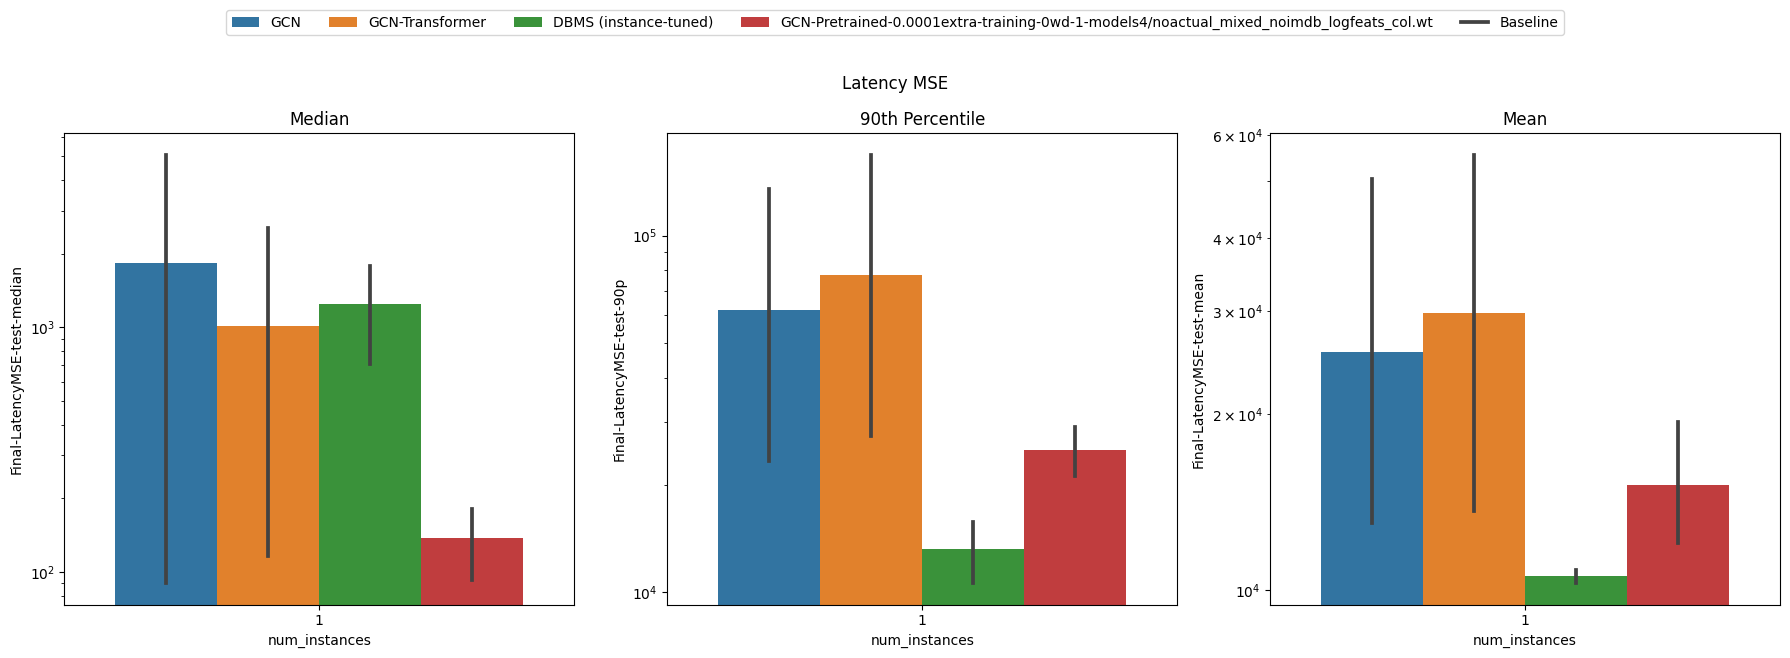

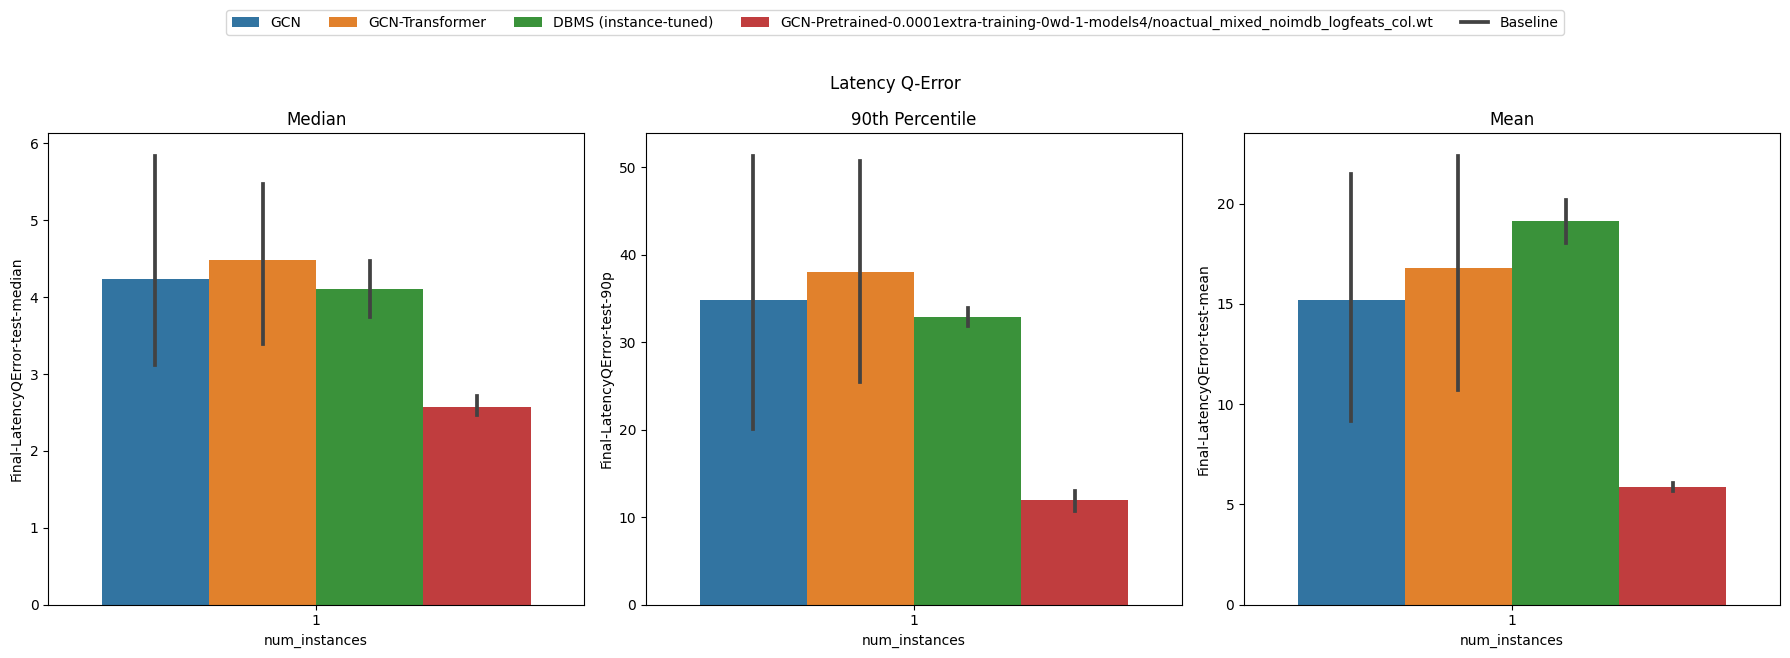

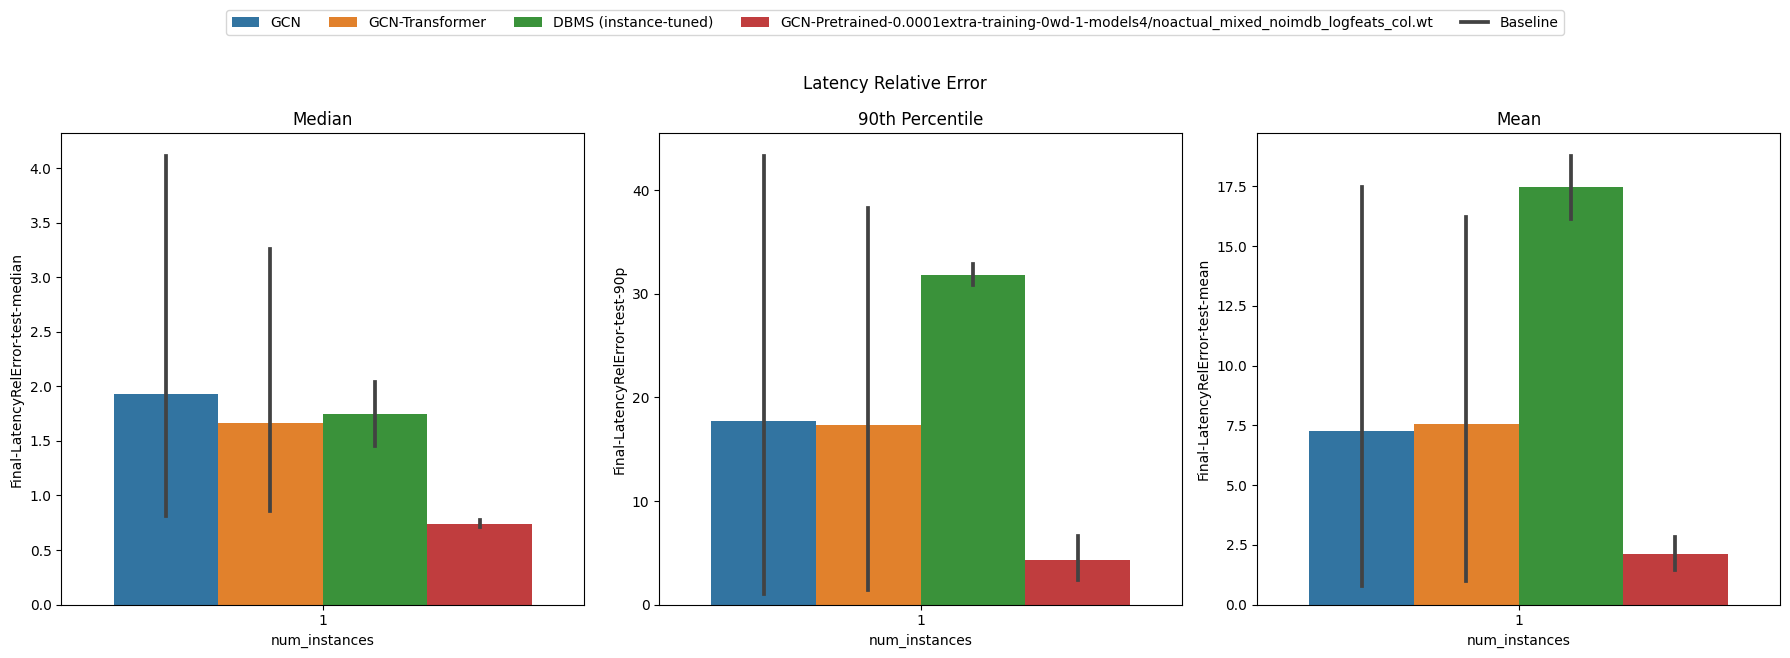

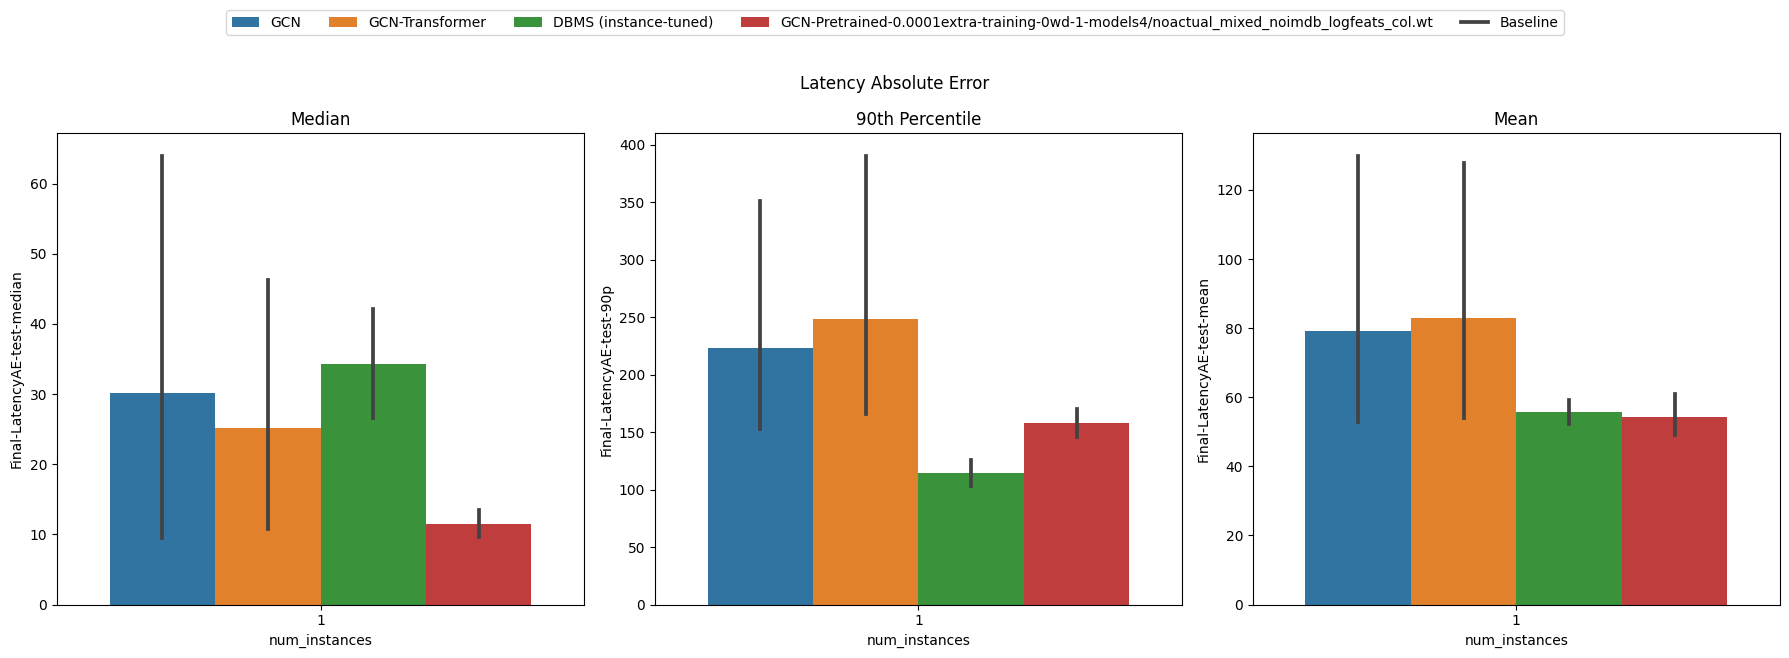

In [81]:

    
tmp = df
# Plot for MSE
plot_metrics(tmp, 
             'Final-LatencyMSE-test-median', 
             'Final-LatencyMSE-test-90p', 
             'Final-LatencyMSE-test-mean',
             'Latency MSE')

# Plot for Q-Error
plot_metrics(tmp, 
             'Final-LatencyQError-test-median', 
             'Final-LatencyQError-test-90p', 
             'Final-LatencyQError-test-mean',
             'Latency Q-Error')

plot_metrics(tmp, 
             'Final-LatencyRelError-test-median', 
             'Final-LatencyRelError-test-90p', 
             'Final-LatencyRelError-test-mean',
             'Latency Relative Error')

# Plot for AE
plot_metrics(tmp, 
             'Final-LatencyAE-test-median', 
             'Final-LatencyAE-test-90p', 
             'Final-LatencyAE-test-mean',
             'Latency Absolute Error')


ValueError: Could not interpret input 'Final-LatencyMSE-test_useen-median'

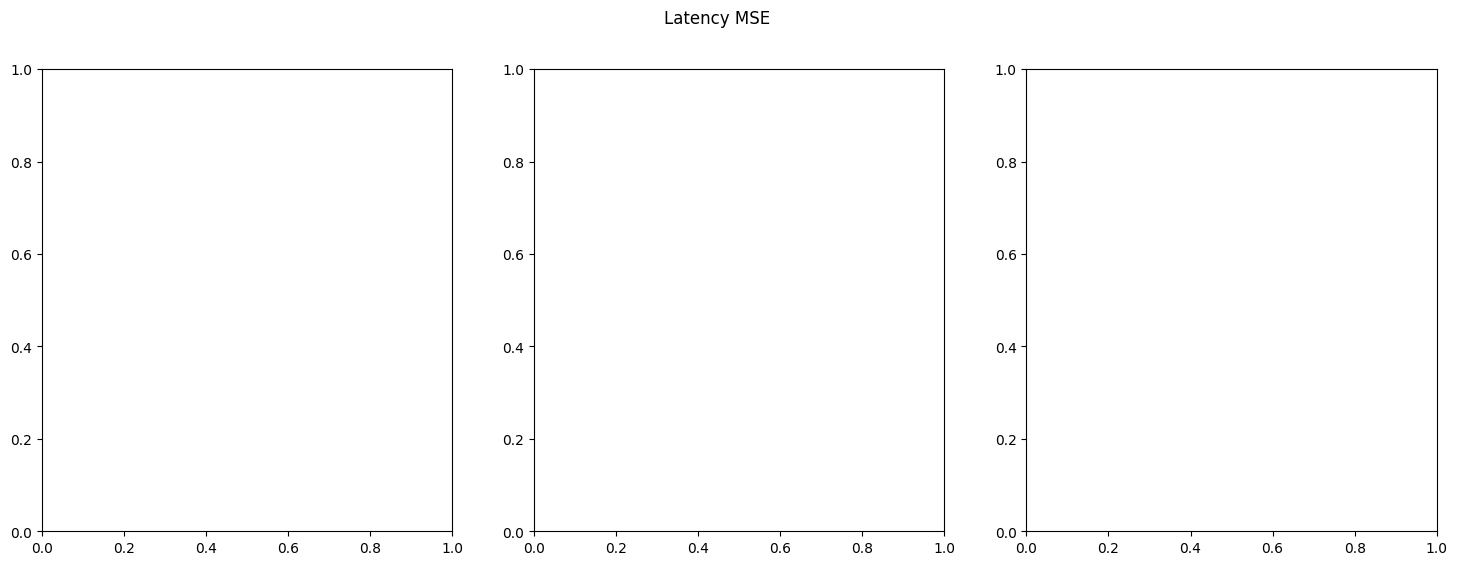

In [82]:
# Loop through each unique workload
# for wk in set(df["workload"]):
#     tmp = df[df["workload"] == wk]
    
tmp = df
# Plot for MSE
plot_metrics(tmp, 
             'Final-LatencyMSE-test_useen-median', 
             'Final-LatencyMSE-test_useen-90p', 
             'Final-LatencyMSE-test_useen-mean',
             'Latency MSE')

# Plot for Q-Error
plot_metrics(tmp, 
             'Final-LatencyQError-test_useen-median', 
             'Final-LatencyQError-test_useen-90p', 
             'Final-LatencyQError-test_useen-mean',
             'Latency Q-Error')

plot_metrics(tmp, 
             'Final-LatencyRelError-test_useen-median', 
             'Final-LatencyRelError-test_useen-90p', 
             'Final-LatencyRelError-test_useen-mean',
             'Latency Relative Error')

# Plot for AE
plot_metrics(tmp, 
             'Final-LatencyAE-test_useen-median', 
             'Final-LatencyAE-test_useen-90p', 
             'Final-LatencyAE-test_useen-mean',
             'Latency Absolute Error')


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of ticklabels (4).

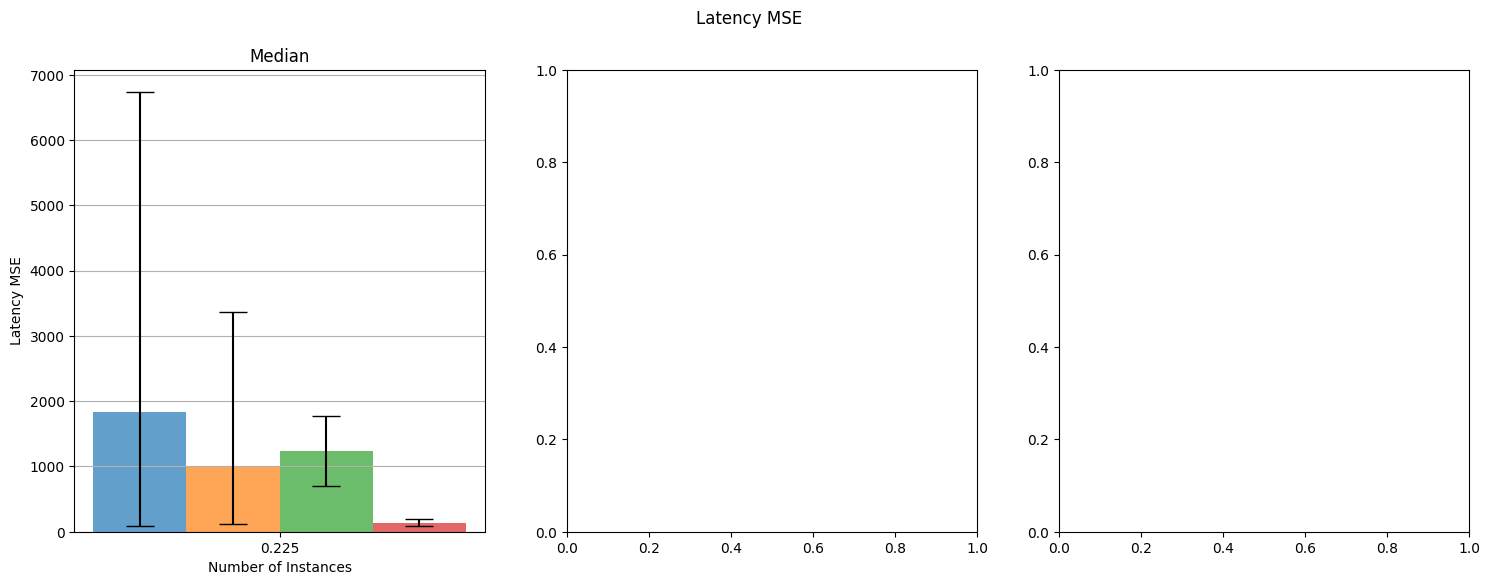

In [83]:
# Plot for MSE
plot_metrics2(tmp, 
             'Final-LatencyMSE-test-median', 
             'Final-LatencyMSE-test-90p', 
             'Final-LatencyMSE-test-mean',
             'Latency MSE')

# Plot for Q-Error
plot_metrics2(tmp, 
             'Final-LatencyQError-test-median', 
             'Final-LatencyQError-test-90p', 
             'Final-LatencyQError-test-mean',
             'Latency Q-Error')

plot_metrics2(tmp, 
             'Final-LatencyRelError-test-median', 
             'Final-LatencyRelError-test-90p', 
             'Final-LatencyRelError-test-mean',
             'Latency Relative Error')

# Plot for AE
plot_metrics2(tmp, 
             'Final-LatencyAE-test-median', 
             'Final-LatencyAE-test-90p', 
             'Final-LatencyAE-test-mean',
             'Latency Absolute Error')


In [22]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Example data for 3 baselines and 5 seeds for each baseline
# baseline_names = ["Baseline1", "Baseline2", "Baseline3"]
# baseline_data = {
#     "Baseline1": [[5, 5.1, 5.8], [5.5, 5.6, 6.1], [6, 6.2, 6.7], [6.1, 6.3, 6.8], [5.9, 6.0, 6.4]],  # Each inner list has [mean, median, 90p]
#     "Baseline2": [[6, 6.1, 6.8], [6.4, 6.5, 7], [6.7, 6.8, 7.3], [6.3, 6.4, 7], [6.1, 6.2, 6.9]],
#     "Baseline3": [[7, 7.1, 7.8], [7.2, 7.3, 8], [7.4, 7.5, 8.2], [7.1, 7.3, 8], [7.2, 7.4, 7.9]]
# }

# means = [np.mean([seed[0] for seed in baseline_data[baseline]]) for baseline in baseline_names]
# medians = [np.mean([seed[1] for seed in baseline_data[baseline]]) for baseline in baseline_names]
# p90s = [np.mean([seed[2] for seed in baseline_data[baseline]]) for baseline in baseline_names]

# # Create bars for means
# bars = plt.bar(baseline_names, means, color='lightblue', label='Mean')

# # Add median points on the bars
# for i, bar in enumerate(bars):
#     plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, medians[i] + 0.1, 'x', ha='center', va='bottom', color='black', fontsize=12, label='Median' if i==0 else "")

# # Add error bars to represent up to the 90p
# plt.errorbar(baseline_names, means, [0]*len(means), [p90 - mean for p90, mean in zip(p90s, means)], fmt='none', ecolor='red', capsize=5, label='90th Percentile')

# plt.ylabel('Value')
# plt.title('Metrics across different baselines')
# plt.legend()
# plt.show()

In [250]:
df[df['alg'] == "DBMS (instance-tuned)"]

,Tags,name,lr,alg,hl1,arch,seed,tags,config,min_est,...,Final-LatencyQError-train-median,Final-LatencyMSE-train-90p,Final-LatencyMSE-test-median,Final-LatencyQError-train-90p,Final-LatencyRelError-test-99p,Final-LatencyRelError-train-median,Final-LatencyAE-train-90p,Final-LatencyMSE-train-mean,test_query_dir,workload
0,"[3a, final5-fixed_instances-min-1]",icy-waterfall-4116,0.00001,DBMS (instance-tuned),512,factorized,1,"exp10_single_zdbs,exp5_single_stats,exp8_singl...",configs/baselines/config_dbms_imdb.yaml,None,...,9.928848,737.231749,179.031049,18.463977,16.435893,8.888694,27.152012,4795.967726,"./queries/ceb-small,./queries/job",Stack


In [178]:
set(df["alg"])

{'DBMS (instance-tuned)',
 'GCN-Pretrained-0.0001extra-training-0wd-0.1-models4/noimdb_actual.wt',
 'GCN-Pretrained-0.0001extra-training-0wd-0.1-models4/noimdb_noactual.wt',
 'GCN-Pretrained-0.0001extra-training-1wd-0.1-models4/noimdb_actual.wt',
 'GCN-Pretrained-1e-05extra-training-0wd-0.1-models4/tpch-ergast-stack_actual.wt',
 'GCN-Pretrained-1e-05extra-training-1wd-0.1-models4/noimdb_noactual.wt',
 'GCN-Pretrained-1e-05extra-training-1wd-0.1-models4/tpch-ergast-stack_actual.wt'}

In [179]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# FN_TMP = "{}-{}.pdf"

# # Define a function to check if the values have a large range and should be plotted in log scale
# def should_use_log_scale(values):
#     return max(values) / min(values) > 100  # Adjust this threshold if needed

# # Define a function to plot the given metrics
# def plot_metrics(data, metric_median, metric_90p, metric_mean, title):
#     fig, axs = plt.subplots(1, 3, figsize=(18,6))
#     plt.suptitle(title)
    
#     # Plot for Median values
#     sns.barplot(data=data, y=metric_median, x="num_instances", hue="alg", dodge=True, ax=axs[0], palette=HUES)
#     axs[0].set_title('Median')
#     if should_use_log_scale(data[metric_median]):
#         axs[0].set_yscale("log")

#     # Plot for 90th Percentile values
#     sns.barplot(data=data, y=metric_90p, x="num_instances", hue="alg", dodge=True, ax=axs[1], palette=HUES)
#     axs[1].set_title('90th Percentile')
#     if should_use_log_scale(data[metric_90p]):
#         axs[1].set_yscale("log")

#     # Plot for Mean values
#     sns.barplot(data=data, y=metric_mean, x="num_instances", hue="alg", dodge=True, ax=axs[2], palette=HUES)
#     axs[2].set_title('Mean')
    
#     if should_use_log_scale(data[metric_mean]):
#         axs[2].set_yscale("log")

#     # Remove individual legends and add a single legend at the top
#     for ax in axs:
#         ax.get_legend().remove()
#     handles, labels = axs[0].get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=len(handles))

#     # Finalize the plot and save
#     plt.tight_layout()
#     fn = FN_TMP.format(wk, title.replace(' ', '-'))
#     print(fn)
#     plt.savefig(fn, bbox_inches="tight")

# # Loop through each unique workload
# for wk in set(df["workload"]):
#     tmp = df[df["workload"] == wk]
    
#     # Plot for MSE
#     plot_metrics(tmp, 
#                  'Final-LatencyMSE-test-median', 
#                  'Final-LatencyMSE-test-90p', 
#                  'Final-LatencyMSE-test-mean',
#                  'Latency MSE')

#     # Plot for Q-Error
#     plot_metrics(tmp, 
#                  'Final-LatencyQError-test-median', 
#                  'Final-LatencyQError-test-90p', 
#                  'Final-LatencyQError-test-mean',
#                  'Latency Q-Error')

    
#     # Plot for Q-Error
#     plot_metrics(tmp, 
#                  'Final-LatencyRelError-test-median', 
#                  'Final-LatencyRelError-test-90p', 
#                  'Final-LatencyRelError-test-mean',
#                  'Latency Relative Error')
    
#     # Plot for AE
#     plot_metrics(tmp, 
#                  'Final-LatencyAE-test-median', 
#                  'Final-LatencyAE-test-90p', 
#                  'Final-LatencyAE-test-mean',
#                  'Latency Absolute Error')

In [180]:
# FN_TMP = "{}-{}.pdf"
# for wk in set(df["workload"]):
#     tmp = df[df["workload"] == wk]
#     EB="ci"
#     TO_PLOT = ['Final-LatencyAE-test-median', 'Final-LatencyAE-test-mean']
#     fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

#     ## train
#     ax = axs[0]
#     sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, 
#                 ax=ax, errorbar=EB, 
#                 palette=HUES)
#     legend = ax.legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
#                        frameon=False)

#     sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=axs[1], 
#                 errorbar=EB, palette=HUES)
#     axs[1].legend().remove()
    
#     fn = FN_TMP.format(wk, "MSE")
#     print(fn)
#     plt.savefig(fn, bbox_inches="tight")
    
#     TO_PLOT = ['Final-LatencyRelError-test-median', 'Final-LatencyRelError-test-90p']
#     fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    
#     ## train
#     sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, ax=axs[0], errorbar=EB,
#                palette=HUES)
#     #axs[0].legend().remove()
#     legend = axs[0].legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
#                frameon=False)
    
#     sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=axs[1], errorbar=EB,
#                palette=HUES)
#     axs[1].legend().remove()
    
#     fn = FN_TMP.format(wk, "Q-Error")
#     print(fn)
#     plt.savefig(fn, bbox_inches="tight")

In [106]:
# FN_TMP = "Test-{}-{}.pdf"
# for wk in set(df["workload"]):
#     tmp = df[df["workload"] == wk]
#     EB="sd"
#     TO_PLOT = ['Final-LatencyAE-train-mean', 'Final-LatencyAE-test-mean']
#     fig,axs = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

#     ## train
# #     ax = axs[0]
# #     sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, 
# #                 ax=ax, errorbar=EB, palette=HUES)
# #     legend = ax.legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
# #                        frameon=False)
    
#     ax = axs
#     sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=ax, 
#                 errorbar=EB, palette=HUES)
#     #axs[1].legend().remove()
#     ax.set_xlabel("Number of training instances", fontsize=20)
#     ax.set_ylabel("Latency AE", fontsize=20)
#     ax.tick_params(axis='both', which='major', labelsize=16)
    
#     fn = FN_TMP.format(wk, "MSE")
#     print(fn)
#     plt.savefig(fn, bbox_inches="tight")
    
#     TO_PLOT = ['Final-LatencyRelError-test-median', 'Final-LatencyRelError-test-90p']
#     fig,axs = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
    
#     ## train
# #     sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, ax=axs[0], errorbar=EB,
# #                palette=HUES)
#     #axs[0].legend().remove()
# #     legend = axs[0].legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
# #                frameon=False)
    
#     ax = axs
#     sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=axs, errorbar=EB,
#                palette=HUES)
    
#     ax.set_xlabel("Number of training instances", fontsize=20)
#     ax.set_ylabel("Latency Rel-Error", fontsize=20)
#     ax.tick_params(axis='both', which='major', labelsize=16)
#     #axs[1].legend().remove()
    
#     fn = FN_TMP.format(wk, "Q-Error")
#     print(fn)
#     plt.savefig(fn, bbox_inches="tight")